# PumpItUp
## DrivenDataCompetition PumpItUp
- All data is within the same folder as notebook

In [1]:
import pandas as pd
import matplotlib as plt
import sklearn
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [87]:
# load training-data and labels
trainingValues = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
trainingLabels = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
trainingData = pd.merge(trainingValues, trainingLabels, on= 'id')

# Investigation and Cleansing of data
Possible data-issues
* population == 0 -> Maybe delete all lines with population?
* num_private Not in feature-description -> Maybe delete column?
* object-data needs to be converted in category-numbers
* idea: funders and installers who fund and install regularly are less porbable to create failing pumps than those who do it less often. Thererfore the names are exchanged with the number of occurances. Same for basin, wpt_name, subvillage, scheme_name and schmeme_management
* recorded_by is always value 'geoData Consultants Ltd' -> drop it

In [3]:
# Describe data
trainingData.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [144]:
# cleanData

# function with dropping of missing values
def cleanData(data : pd.DataFrame):
    data.dropna(inplace = True)    
    data = data[data.population != 0] # delete population == 0        
    return cleansing(data)

# function with substitution of missing values
def cleanDataWithoutDropping(data : pd.DataFrame):
    data['public_meeting'] = data['public_meeting'].fillna('True') #fill nan with 'True'
    data['permit'] = data['permit'].fillna('True')
    return cleansing(data)


def cleansing(data : pd.DataFrame):
    
    if 'num_private' in data.columns: # drop 'num_private'
        data = data.drop('num_private', axis = 1)
    
    if 'recorded_by' in data.columns: # drop 'recorded_by'
        data = data.drop('recorded_by', axis = 1) 
    
    #clean funder-column
    replacementDictionary = {'a/co germany' : 'aco', 'aco/germany': 'aco', 'world vision' : 'worldvision', 'world vision/ kkkt' : 'worldvision', 'world vision/adra' : 'worldvision', 
                        'world vision/rc church' : 'worldvision', 'women fo partnership' : 'women for partnership', 'acord ngo' : 'acord', 'zao water spring x': 'zao', 'zao water spring' : 'zao',
                             'world bank/government' : 'world bank', 'wwf / fores' : 'wwf', 'yasini selemani' : 'yasini', 'adp bungu' : 'adp', 'adp mombo' : 'adp', 'adp/w' : 'adp',
                        'private' : 'unknown', 'private institutions': 'unknown', 'not known': 'unknown', 'private individual' : 'unkown', 'de' : 'germany',  'water aid /sema' : ' wateraid',
                        'japan government' : 'japan', 'china government': 'china', 'unicef/ csp' : 'unicef',  'private individul' : 'unknown', 'private co' : 'unknown', 'unicef/cspd' : 'unicef', 
                             'embasy of japan in tanzania' : 'japan' ,'tz japan' : 'japan', 'government of tanzania' : 'tanzania', 'kkkt church' : 'kkkt', 'ms' : 'unknown', 'aic' : 'aict', 'anrikana': 'angrikana',
                            'schoo' : 'school', 'school adm9nstrarion' : 'school', 'school administration' : 'school', 'school capital':'school', 'Serikali Ya Kijiji' : 'serikali', 'swedish tandala project' : 'swedish', 
                             'swiss if':'swiss', 'swisland/ mount meru flowers':'swisland', 'tanzania and egypt cooperat' : 'tanzania', 'tanzania christian service' : 'tanzania', 'tanzania na egypt' : 'tanzania', 
                             'tanzania nea egypt' : 'tanzania', 'tassaf i' : 'tassaf', 'tassaf ii' : 'tassaf', 'tassaf/ danida' : 'tassaf', 'tanzania/australia' : 'tanzania', 'tcrs /care' : 'tcrs', 'tcrs /government' : 'tcrs', 
                             'tcrs/village community' : 'tcrs', 'unice' : 'unicef'}
    data['funder'] = data['funder'].astype(str)
    data['funder'] = data['funder'].apply(lambda x: x.strip().lower())
    data['funder'] = data['funder'].replace(replacementDictionary)
    data['funder'] = data['funder'].astype('object')

        
        
    # list of columns
    columns = ['funder','installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management']
    
    for columnName in columns: # make all strings lower case and replace names with number of occurence.
        data[columnName] = data[columnName].fillna('unknown')
        data.loc[data[columnName].str.len() <=2, columnName] = 'unknown'
        data.loc[data[columnName] == 'none', columnName] = 'unknown'
        data[columnName].str.lower()
        data = data.replace({columnName : data[columnName].value_counts().to_dict()})
    

    

    
    #change data-recorded to year- and month-only-columns
    data['date_recorded'] = pd.to_datetime(data['date_recorded'], format='%Y-%m-%d')
    data['year_recorded'] =data['date_recorded'].dt.year
    data['year_recorded'] = data['year_recorded'].astype('object')

    data['month_recorded'] = data['date_recorded'].dt.month
    data['month_recorded'] = data['month_recorded'].astype('object')
    
    data['day_recorded'] = data['date_recorded'].dt.day
    data['day_recorded'] = data['day_recorded'].astype('object')

    data = data.drop('date_recorded', axis = 1)
    
    #change labels to category data
    cat_columns = data.select_dtypes(['object']).columns
    if len(cat_columns) == 0:
        return data
    data[cat_columns] = data[cat_columns].astype('category')
    cat_data = data[cat_columns].apply(lambda x: x.cat.codes)
    data = data.join(cat_data, rsuffix='_cat')
    
        
    return data



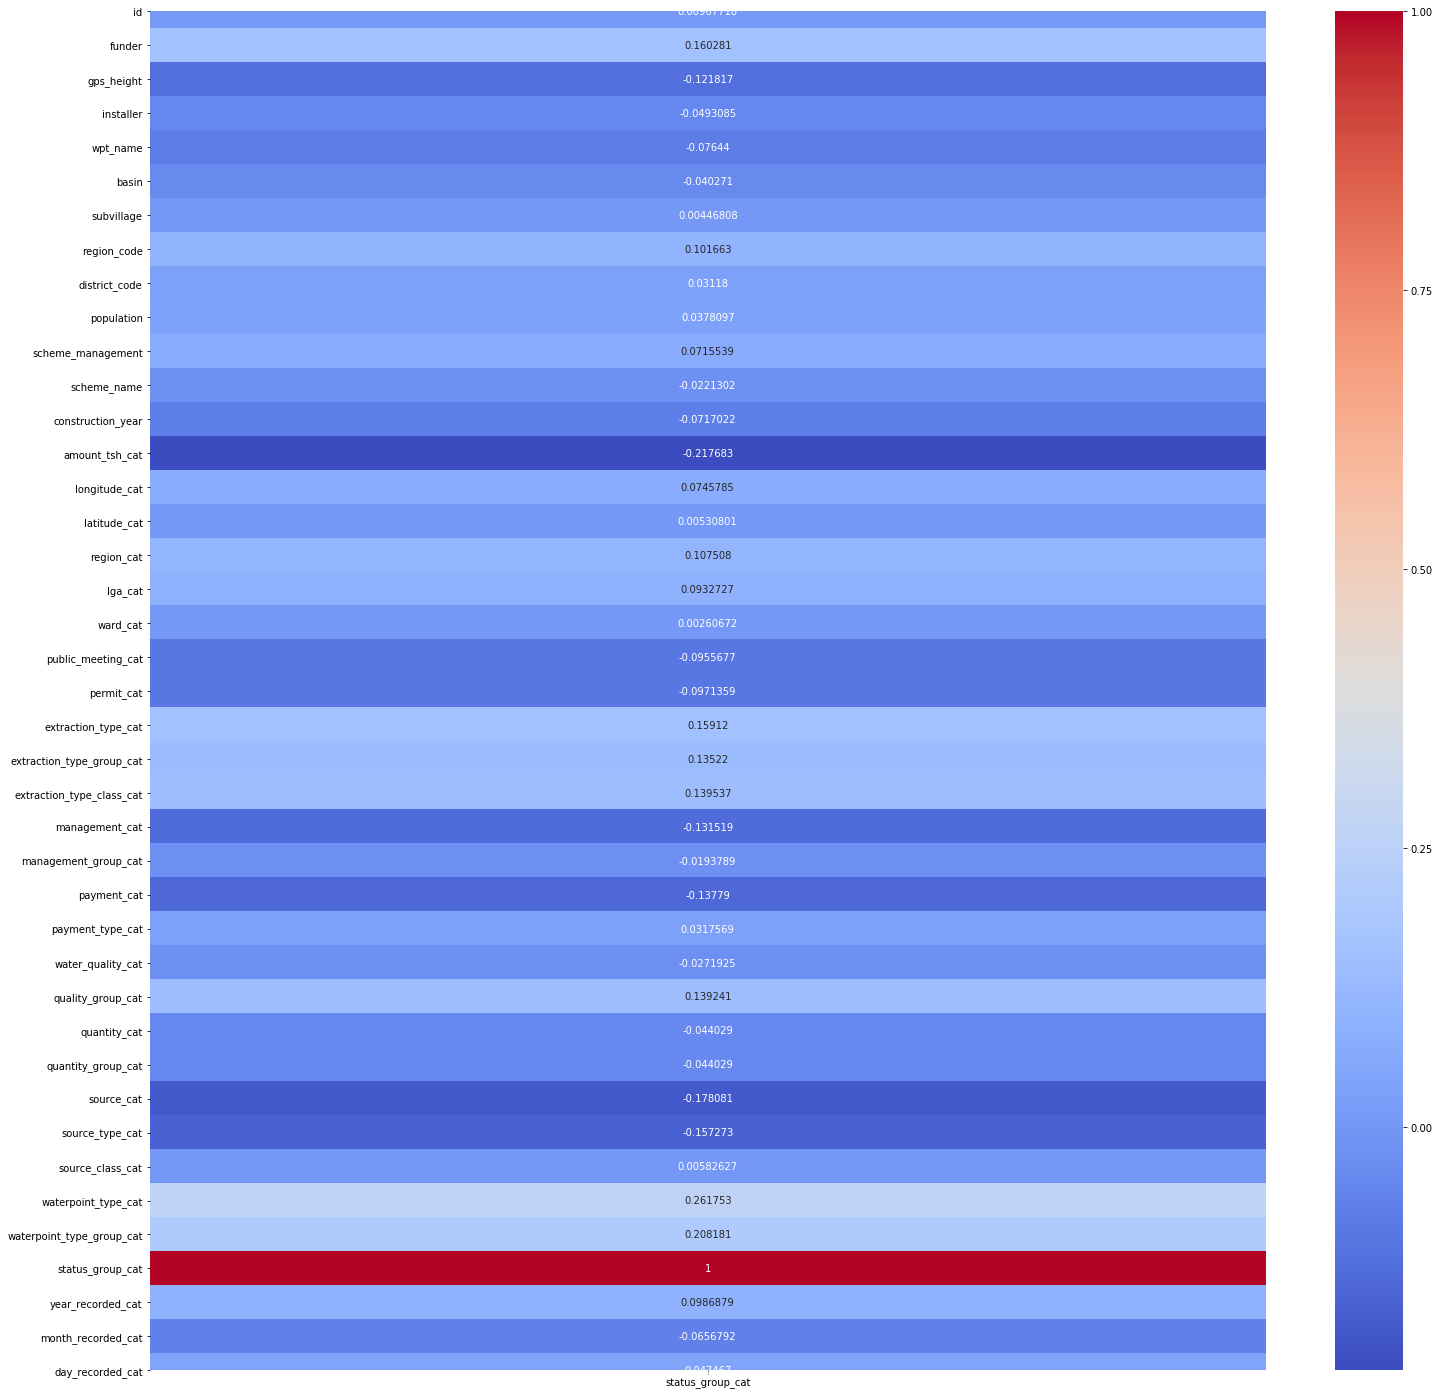

In [145]:
#check correlation
data = cleanData(trainingData)
fig = plt.pyplot.gcf() 
fig.set_size_inches(25,25)
data = pd.DataFrame(data.corr()['status_group_cat'])
no_use_columns = data.select_dtypes(['category']).columns
data = data.drop(no_use_columns, axis=1)

sns.heatmap(data, annot = True, fmt='g',cmap= 'coolwarm')

In [8]:
# prepare data

def prepareData(data):
    #split in labels and features
    labels = data['status_group_cat']
    features = data.drop(['status_group_cat','id'],axis=1)
    no_use_columns = features.select_dtypes(['category']).columns
    features = features.drop(no_use_columns, axis=1)
    features_list = features.columns

    #split labels and features is train-data and test-data
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

    #check shape
    if (train_features.shape != train_labels.shape) or (test_features.shape != test_labels.shape):
        print ('ERROR: Shape of data failed: ', train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)
    
    return train_features, test_features, train_labels, test_labels

In [11]:
#Experiment 1: Deleting works better than substitution
# (Accuracy 0.8343399482312338 in comparison to 0.8146801346801347)
DONE = True
if DONE is False:
    randomForest = RandomForestClassifier(n_estimators= 1600, min_samples_split= 5, min_samples_leaf= 1, max_depth= 100, bootstrap= True, max_features= 'auto')
    

    
    trainingDataV1 = cleanDataV1(trainingData.copy(), ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'])
    print('dataV1 cleaned')
    trainingDataV2 = cleanDataV2(trainingData.copy(), ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'])
    print('dataV2 cleaned')
    train_features, test_features, train_labels, test_labels = prepareData(trainingDataV1)
    print('dataV1 prepared')
    randomForest.fit(train_features, train_labels)
    predictions = randomForest.predict(test_features)
    accuracyV1 = sklearn.metrics.accuracy_score(test_labels, predictions)
    print("accuracyV1: ", accuracyV1)
    train_features, test_features, train_labels, test_labels = prepareData(trainingDataV2)
    print ('dataV2 prepared')
    randomForest.fit(train_features, train_labels)
    predictions = randomForest.predict(test_features)
    accuracyV2 = sklearn.metrics.accuracy_score(test_labels, predictions)
    print("accuracyV2: ", accuracyV2)
        


In [6]:
#Experiment 2: Which substitution values work better for prediction?
# Values for 'public_meeting' and 'permit' have no effect on accuracy. Can be set to any value.
    
DONE = True
if DONE is False:
    randomForest = RandomForestClassifier(n_estimators= 1600, min_samples_split= 5, min_samples_leaf= 1, max_depth= 100, bootstrap= True, max_features= 'auto')
    data = cleanData(trainingData.copy(), ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'])
    print('data is cleaned')
    train_features, test_features, train_labels, test_labels = prepareData(data)
    print('data is prepared')
    
    randomForest.fit(train_features, train_labels)
    
    testDataV1 = cleanDataWithoutDropping(trainingData.copy(), ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'], True, False)
    testDataV2 = cleanDataWithoutDropping(trainingData.copy(), ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'], False, True)
    testDataV3 = cleanDataWithoutDropping(trainingData.copy(), ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'], False, False)
    
    _, prepared_test_featuresV1, _, prepared_test_labelsV1 = prepareData(testDataV1)
    _, prepared_test_featuresV2, _, prepared_test_labelsV2 = prepareData(testDataV2)
    _, prepared_test_featuresV3, _, prepared_test_labelsV3 = prepareData(testDataV3)
    
    predictions = randomForest.predict(prepared_test_featuresV1)
    accuracyV1 = sklearn.metrics.accuracy_score(prepared_test_labelsV1, predictions)
     
    predictions = randomForest.predict(prepared_test_featuresV2)
    accuracyV2 = sklearn.metrics.accuracy_score(prepared_test_labelsV2, predictions)
    
    predictions = randomForest.predict(prepared_test_featuresV3)
    accuracyV3 = sklearn.metrics.accuracy_score(prepared_test_labelsV3, predictions)
    
    print('AccuarcyV1: ', accuracyV1, ' True, False')
    print('AccuarcyV2: ', accuracyV1, ' False, True')
    print('AccuarcyV3: ', accuracyV1, ' False, False')

data is cleaned
ERROR: Shape of data failed
data is prepared
ERROR: Shape of data failed
ERROR: Shape of data failed
ERROR: Shape of data failed
AccuarcyV1:  0.7424915824915825  True, False
AccuarcyV2:  0.7424915824915825  False, True
AccuarcyV3:  0.7424915824915825  False, False


In [9]:
# Experiment 3: Does use of frequency for funder, installer, etc gain accuracy? test-level of accuracy is 0.7424915824915825
# Gain in accuarcy by use of 'number of occurances' as category 
DONE = True

def cleanData(data : pd.DataFrame, columns):
    if 'num_private' in data.columns: # drop 'num_private'
        data = data.drop('num_private', axis = 1)
    
    data['public_meeting'] = data['public_meeting'].fillna('True')
    data['permit'] = data['permit'].fillna('False')
    
    for columnName in columns: # make all strings lower case and replace names with number of occurence.
        data[columnName] = data[columnName].fillna('unknown')
        data.loc[data[columnName].str.len() <=2, columnName] = 'unknown'
        data.loc[data[columnName] == 'none', columnName] = 'unknown'
        data[columnName].str.lower()
        data[columnName] = data[columnName].astype('object')
        
    #change data-recorded to year- and month-only-columns
    data['date_recorded'] = pd.to_datetime(data['date_recorded'], format='%Y-%m-%d')
    data['year_recorded'] =data['date_recorded'].dt.year
    data['year_recorded'] = data['year_recorded'].astype('object')

    data['month_recorded'] = data['date_recorded'].dt.month
    data['month_recorded'] = data['month_recorded'].astype('object')
    
    data['day_recorded'] = data['date_recorded'].dt.day
    data['day_recorded'] = data['day_recorded'].astype('object')

    data = data.drop('date_recorded', axis = 1)
    
    dataV2 = data.copy()
    
    for columnName in columns:
        data = data.replace({columnName : data[columnName].value_counts().to_dict()})
    
    #change labels to category data
    cat_columns = data.select_dtypes(['object']).columns
    data[cat_columns] = data[cat_columns].astype('category')
    cat_data = data[cat_columns].apply(lambda x: x.cat.codes)
    data = data.join(cat_data, rsuffix='_cat')
    
    cat_columns = dataV2.select_dtypes(['object']).columns
    dataV2[cat_columns] = dataV2[cat_columns].astype('category')
    cat_data = dataV2[cat_columns].apply(lambda x: x.cat.codes)
    dataV2 = dataV2.join(cat_data, rsuffix='_cat')
    
        
    return data, dataV2

if DONE is not True:
    randomForest = RandomForestClassifier(n_estimators= 1600, min_samples_split= 5, min_samples_leaf= 1, max_depth= 100, bootstrap= True, max_features= 'auto')
    data, dataV2 = cleanData(trainingData.copy(), ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'])
    train_features, test_features, train_labels, test_labels = prepareData(data)
    randomForest.fit(train_features, train_labels)
    predictions = randomForest.predict(test_features)
    print('Accuracy with numberOfOccurances is: ', sklearn.metrics.accuracy_score(test_labels, predictions))
    train_features, test_features, train_labels, test_labels = prepareData(dataV2)
    randomForest.fit(train_features, train_labels)
    predictions = randomForest.predict(test_features)
    print('Accuracy without numberOfOccurances is: ', sklearn.metrics.accuracy_score(test_labels, predictions))   

ERROR: Shape of data failed:  (44550, 40) (44550,) (14850, 40) (14850,)
Accuracy with numberOfOccurances is:  0.8145454545454546
ERROR: Shape of data failed:  (44550, 40) (44550,) (14850, 40) (14850,)
Accuracy without numberOfOccurances is:  0.8138720538720539


In [17]:
trainingDataV1.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,quantity_group_cat,source_cat,source_type_cat,source_class_cat,waterpoint_type_cat,waterpoint_type_group_cat,status_group_cat,year_recorded_cat,month_recorded_cat,day_recorded_cat
0,69572,6000.0,275,1390,94,34.938093,-9.856322,3591,5085,6,...,1,8,6,0,1,1,0,2,2,13
1,8776,0.0,53,1399,39,34.698766,-2.147466,830,10248,5,...,2,5,3,1,1,1,0,4,2,5
2,34310,25.0,8,686,408,37.460664,-3.821329,3,8940,502,...,1,0,1,1,2,1,0,4,1,24
3,67743,0.0,1057,263,222,38.486161,-11.155298,1,4493,17,...,0,3,0,0,2,1,2,4,0,27
4,19728,0.0,1,0,135,31.130847,-1.825359,1748,10248,2,...,3,5,3,1,1,1,0,2,6,12


# Try random forest


In [ ]:
## Try random fit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle

##create random grid
# number of trees in forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop= 2000, num = 100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 5, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method for selecting samples for training each node
bootstrap = [True, False]
# max features
max_features = ['auto', 'log2', 'sqrt']

random_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap}

randomforest = RandomForestClassifier()

randomforest_random = RandomizedSearchCV(estimator = randomforest, param_distributions=random_grid, n_iter = 100, cv= None, verbose= 20, random_state= 42, n_jobs = -1)
randomforest_random.fit(features, labels)
best_estimator = randomforest_random.best_estimator_

# Show parameters
print('Best parameters: ',randomforest_random.best_params_)

# Show Accuracy
predictions = best_estimator.predict(test_features)
print ('Accuracy-Score of randomforest is: ', sklearn.metrics.accuracy_score(test_labels, predictions))



In [41]:



def competitionOutput(filenameIn, filenameOut ,estimator):
    # prepare competition features
    competition_features = pd.read_csv(filenameIn)
    print('competition_features shape: ',competition_features.shape)
    competition_features_prepared = cleanDataWithoutDropping(competition_features, ['funder', 'installer','wpt_name','basin', 'subvillage','scheme_name', 'scheme_management'], True, True)
    competition_features_prepared = competition_features_prepared.drop(['id'],axis=1)
    no_use_columns = competition_features_prepared.select_dtypes(['category']).columns
    competition_features_prepared = competition_features_prepared.drop(no_use_columns, axis=1)
    
    print('competition features prepared shape: ', competition_features_prepared.shape)

    predictions = estimator.predict(competition_features_prepared)
    print('shape predictions', predictions.shape)
    competition_result = pd.read_csv(filenameIn)
    print('shape competition_result', competition_result.shape)
    competition_result['status_group'] = predictions
    competition_result = competition_result[['id', 'status_group']]
    competition_result['status_group'] = competition_result['status_group'].replace([0,1,2],['functional','functional needs repair', 'non functional'])

    # create output csv
    competition_result.to_csv(filenameOut, index=False)
    return competition_features_prepared

competition_features_prepared = competitionOutput('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv', 'predictionsV4.csv', randomForest)
competition_features_prepared.columns[competition_features_prepared.isna().any()].tolist()

competition_features shape:  (14850, 40)
competition features prepared shape:  (14850, 40)
shape predictions (14850,)
shape competition_result (14850, 40)


[]

NameError: name 'competition_features_prepared' is not defined